# Surface Water-Mass Transformation 

In this notebook, we compute surface water-mass transformation rates (both in the net and partitioned into contributions from heat and salt fluxes) for the southern ocean, south of 60$^\circ$S. 

This notebook is partially model-agnostic, i.e., it should work with ACCESS-OM2 (*MOM5*) and *MOM6* simulations. It cannot be considered fully model agnostic however, as diagnostics used for the surface water mass transformation calculation considerably differ between models. An embedded dictionary automatically identifies the correct forcing, once the user points out which ocean model is being analyzed.

## 1. Defining surface water-mass transformation

The surface water-mass transformation framework described here follows [Newsom *et al* (2016)](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-15-0513.1) and [Abernathey *et al* (2016)](https://www.nature.com/articles/ngeo2749). Surface water-mass transformation may be defined as the volume flux into a given density class ($\sigma$) from lighter density classes ($\sigma'<\sigma$) due to surface buoyancy forcing. Integrated over a region of the ocean surface, this volume flux can be expressed as,

$$
\begin{equation}
\Omega(\sigma, t) = \frac{\partial}{\partial\sigma} \iint_{\sigma'<\sigma} \Big(\frac{\partial\sigma}{\partial\theta}\theta + \frac{\partial\sigma}{\partial S}S\Big) \, \mathrm{d}x \, \mathrm{d}y
\end{equation}
$$

where $t$ is time, and the terms in the integrand are the potential temperature ($\theta$) flux and salinity ($S$) flux components of the surface buoyancy flux. The linearity of this expression means we can extract the relative contributions of heat ($\Omega_\text{heat}$) and salinity ($\Omega_\text{fw}$) fluxes to surface water-mass transformation, highlighting driving mechanisms.

## 2. Requirements

**The cosima-cookbook**: The `conda/analysis3-22.10` (or later) module on NCI (or your own up-to-date cookbook installation).

**Model diagnostics**: This notebook can be used for either MOM5 or MOM6 simulations. The *save_SWMT* function has an embedded dictionary that automatically identifies the correct diagnostics to be used for the water mass transformation in each model simulation.

**Warning:** For ACCESS-OM2 this model sums up individual surface buyancy flux components, so it does not reproduce biases in the `net_sfc_heating` diagnostics (see this [git issue](https://github.com/COSIMA/access-om2/issues/139) from March 2019).

For ACCES-OM2 (*MOM5*) we'll need at least monthly resolution (in `diag_table` language...): `surface_temp`, `surface_salt`, `pme_net`, `sfc_salt_flux_restore`,`sfc_hflux_from_runoff`, `sfc_hflux_coupler`, `sfc_hflux_pme` and `frazil_3d_int_z` (although the latter is not strictly a surface flux, instead frazil heat fluxes are vertically integrated over the column. BUT this variable is highly surface intensified and, in most cases, conceptually relevant to what we want to know from SWMT analysis) plus some basic gridding information.

For *MOM6* we'll need at least monthly resolution (in `diag_table` language...): 
`wfo` (Water flux into the ocean), `salt_flux` (net salt flux into the ocean) and `hfds` (net heat flux)

## 3. Computing surface water-mass transformation

First, import some required modules and functions.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 


import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
import cf_xarray as cfxr
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

You should also set up a `dask` client - this code uses the vanilla method for doing this. We suggest using Gadi and an entire node (48 cores) for this calculation.

In [2]:
## once you've set up a dask-worker, connect to it, click the dashboard link to check worker status
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46527/status,
Dashboard: /proxy/46527/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41203,Workers: 7
Dashboard: /proxy/46527/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:38439,Total threads: 4
Dashboard: /proxy/41031/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:42327,


You can use the cosima cookbook tutorial to identify what is the ocean model component of your simulation. For reference, ACCESS-OM2 is *mom5*, while ACCESS-OM3 and Pan-Antarctic are *mom6*

In [3]:
session = cc.database.create_session()

#### The function below will compute  surface water-mass transformation rates for the southern ocean, averaged over an integer number of years of monthly resolution output. Below I have flagged some possible modifications you may want/need to employ: 

- If you are not computing net surface heat fluxes from its components in *MOM5* (here we define `net_surface_heating = sfc_hflux_from_runoff + sfc_hflux_coupler + sfc_hflux_pme + frazil_3d_int_z`), the function below will need to be modified to account for this.
- If you are not looking at the southern ocean, alter the `latitude` slicing regime.
- You may want to use a different density binning array (`isopycnal_bins`)  if the phenomena you're interested in occurs in a shifted density space.
- We use $\sigma_1$ here because we are interested in dense waters that subduct to the Antarctic continental shelf <1000 m depth. You may want to use $\sigma_0$, $\sigma_2$ or something else. If so, alter the `gsw` function used, and define a more appropriate `isopycnal_bins` array.
- If you're looking at a non-interval number of years, the time averaging scheme will need to be modified.
- If you're online computed temperatures (SST) are potential temp (as opposed to conservative temp), use the gsw function `CT_from_pt` before the `sigma1` function as `sigma1` takes conservative temperature input (more info on the TEOS-10 gsw functions [here](http://www.teos-10.org/pubs/gsw/v3_04/html/gsw_contents.html)). This is the case for older ACCESS-OM2-01 runs (e.g. spinup6).
- On this `dask` setup and with the memory constraints of the VDI we don't think you would be able to do much more than a 5 year average of 0.1$^\circ$ data using this function. You are memory-limited by the numpy TEOS-10 gsw functions. If you need to average over more years, you mey have to do the TEOS-10 gsw translations separately and save these prior to computing transformation rates.

When analysing 0.1$^\circ$ output we tend to compute + save and reload surface water-mass transformation diagnostics in separate steps. In part this is because the computations take a while (~13min for 5 years of data below), but we also find that there's some instability (my workers are always killed) if we instead `return net_transformation, heat_transformation, salt_transformation` and then manipulate these variables straight away (a mystery for another mind). Saving and reloading works fine however.

In [4]:
def save_SWMT(expt, session, start_time, end_time, outpath, model='mom6', lat_north = -59, n = None):
    '''
    Computes southern ocean surface water-mass transformation rates (partitioned into transformation from heat 
    and freshwater) referenced to 1000 db from monthly ACCESS-OM2 output.
    Suitable for analysis of high-resolution (0.1 degree) output (the scattered .load()'s allowed this)
    
    expt - text string indicating the name of the experiment
    session - a database session created by cc.database.create_session()  
    start_time - text string designating the start month of the analysis ('YYYY-MM', e.g. '1905-01')
    end_time - text string indicating the end month of the analysis ('YYY-MM', e.g. '1905-12')
    outpath - text string indicating directory where output databases are to be saved (3 xarray databases, can
    modify to combine these if memory permits)
    lat_north - function computed processes between lat = -90 and lat = lat_north
    n - designate if a subset of output files is to be considered (see cc.querying.getvar)
    model - ocean model (either mom5 or mom6)

    This code is not trully model-agnostic, as the different surface forcing fields are not recognizible by cf-xarray. 
    A dictionary is embedded in the function to deal with the different forcing fields
    
    NOTE: this function assumes you are averaging over an integer number of years (though the start month 
    need not be january, e.g. can have start_time = '1905-05', end_time = '1907-04' etc), modify if otherwise.
    
    NOTE: assumes surface_temp and surface_salt variables are in potential temperature (K) and practical
    salinity (PSU), simplifications may be made if conservative temperature (C) and absolute salinity (g/kg)
    are computed online
    
    required modules:
    xarray as xr
    numpy as np
    cosima_cookbook as cc
    from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
    '''

    model_vars = {
        "mom5": {
            "temperature" : "temp",
            "salinity" : "salt",
            "water_flux_into_ocean": "pme_net",
            "salt_from_ice":"sfc_salt_flux_ice",
            "salt_from_restoring":"sfc_salt_flux_restore",
            "heat_from_coupler":"sfc_hflux_coupler",
            "heat_from_runoff":"sfc_hflux_from_runoff",
            "heat_from_frazil":"frazil_3d_int_z",
            "heat_from_prec":"sfc_hflux_pme",
            "geolon":"geolon_t",
            "geolat":"geolat_t",
            "area":"area_t",
            "maximum_depth":"ht",
            "contour_dir":"/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
            "chunks": {"time": '200MB'}
        },
        "mom6": {
            "temperature" : "thetao",
            "salinity" : "so",
            "water_flux_into_ocean": "wfo",
            "net_salt_flux":"salt_flux",
            "net_heat_flux":"hfds",
            "geolon":"geolon",
            "geolat":"geolat",
            "area":"areacello",
            "maximum_depth":"deptho",
            "chunks": {"time":  '200MB'},
        }
    }

    
    ## getvar all required variables
    T = cc.querying.getvar(expt, model_vars[model]['temperature'], session, frequency='1 monthly',chunks=model_vars[model]['chunks']) # SST - conservative temperature 
    st_ocean = T.cf['vertical'].load()
    SST= T.cf.isel({'vertical':0}); del T
    if SST.cf.isel({'time':0}).max().values >100: SST = SST - 273.15 # Convert Kelvin to Celsius, if necessary
    SSS_PSU = cc.querying.getvar(expt, model_vars[model]['salinity'], session, frequency='1 monthly',chunks=model_vars[model]['chunks']).cf.isel({'vertical':0})      # SSS - practical salinity (not absolute)
    pme_net = cc.querying.getvar(expt, model_vars[model]['water_flux_into_ocean'], session, frequency='1 monthly',chunks=model_vars[model]['chunks'])       # mass flux of precip - evap + river
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005 * melt instead
    # Do we have total salt flux saved in one output? If not, then sum salt flux from sea ice and from restoring to get it. 
    if "net_salt_flux" in model_vars[model]: 
        salt_flux = cc.querying.getvar(expt, model_vars[model]["net_salt_flux"], session, frequency='1 monthly',chunks=model_vars[model]['chunks'])
    else:
        salt_flux = ( cc.querying.getvar(expt, model_vars[model]["salt_from_ice"], session, frequency='1 monthly',chunks=model_vars[model]['chunks']) +\
        cc.querying.getvar(expt, model_vars[model]["salt_from_restoring"], session, frequency='1 monthly',chunks=model_vars[model]['chunks']) )
    geolon_t = cc.querying.getvar(expt, model_vars[model]["geolon"], session, n=1)
    geolat_t = cc.querying.getvar(expt, model_vars[model]["geolat"], session, n=1)

    # Do we have net heat fluxes saved in one output? If not, then sum heat flux components to obtain it
    if "net_heat_flux" in model_vars[model]: 
            net_surface_heating = cc.querying.getvar(expt, model_vars[model]["net_heat_flux"], session, frequency='1 monthly',\
                                                     start_time=start_time, end_time=end_time,chunks=model_vars[model]['chunks'])
    else:## compute net surface heat flux from its component terms
         heat_from_runoff = cc.querying.getvar(expt, model_vars[model]["heat_from_runoff"], session, frequency='1 monthly',chunks=model_vars[model]['chunks'])# W/m2
         heat_from_coupler = cc.querying.getvar(expt, model_vars[model]["heat_from_coupler"], session, frequency='1 monthly',chunks=model_vars[model]['chunks'])# W/m2
         heat_from_prec = cc.querying.getvar(expt, model_vars[model]["heat_from_prec"], session, frequency='1 monthly',chunks=model_vars[model]['chunks'])# W/m2
         heat_from_frazil = cc.querying.getvar(expt, model_vars[model]["heat_from_frazil"], session, frequency='1 monthly',chunks=model_vars[model]['chunks'])# W/m2
         net_surface_heating = heat_from_runoff + heat_from_coupler + heat_from_prec + heat_from_frazil # W/m2

    
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time, end_time)
    lat_slice = slice(-90, lat_north)
    SST = SST.cf.sel({'time':time_slice,'latitude':lat_slice})
    SSS_PSU = SSS_PSU.cf.sel({'time':time_slice,'latitude':lat_slice})
    pme_net = pme_net.cf.sel({'time':time_slice,'latitude':lat_slice})
    salt_flux = salt_flux.cf.sel({'time':time_slice,'latitude':lat_slice})
    net_surface_heating = net_surface_heating.cf.sel({'time':time_slice,'latitude':lat_slice})
    
    lon_t = geolon_t.cf.sel({'latitude':lat_slice})
    lat_t = geolat_t.cf.sel({'latitude':lat_slice})
    
    ## extract coordinate arrays
    yt_ocean = SST.cf['latitude'].values
    xt_ocean = SST.cf['longitude'].values
    time_monthly = SST.time.values
    
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SST.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap

    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')


    
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0 + 1) * depth
    pressure = p_from_z(depth_tile, lat_t)
    pressure.attrs = {'units': 'dbar'}
    
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU, pressure, lon_t, lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time',SST.cf['latitude'].name, SST.cf['longitude'].name], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time',SST.cf['latitude'].name, SST.cf['longitude'].name], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = pot_rho_1.load()
    
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time',SST.cf['latitude'].name, SST.cf['longitude'].name], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})

    # Note that the salt fluxes have units of (kg of salt)/m²/s, while β has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_net` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m²/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    salt_transformation = haline_contraction * (SSS * pme_net - (salt_flux)*1000) * days_per_month #! before was PSU, why?
    salt_transformation = salt_transformation.load()

    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time',SST.cf['latitude'].name, SST.cf['longitude'].name], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
    heat_transformation = thermal_expansion * net_surface_heating * days_per_month
    heat_transformation = heat_transformation.load()
    
    # Record the time bounds before summing through time (just to make sure it's consistent with requested years)
    time_bounds = str(salt_transformation.coords['time.year'][0].values)+'_'+str(salt_transformation.coords['time.month'][0].values)+'-'+str(salt_transformation.coords['time.year'][-1].values)+'_'+str(salt_transformation.coords['time.month'][-1].values)
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) ## alter if this density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
    
    bin_bottoms = isopycnal_bins[:-1]
    binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', SST.cf['latitude'].name, SST.cf['longitude'].name], name = 'salt transformation in isopycnal bins summed over time')
    binned_salt_transformation.chunk({'isopycnal_bins':1})
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform
    print('salt_transformation binning done')
    
    binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins',SST.cf['latitude'].name, SST.cf['longitude'].name], name = 'heat transformation in isopycnal bins summed over time')
    binned_heat_transformation.chunk({'isopycnal_bins':1})

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (heat_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform
    print('heat_transformation binning done')
    
    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation/ndays
    c_p = 3992.1
    heat_transformation = binned_heat_transformation/c_p/ndays
    
    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2
    
    # this procedure defines fluxes from lighter to denser classes as negative, I want the opposite
    salt_transformation = salt_transformation *-1
    heat_transformation = heat_transformation *-1


    # Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
    ds = xr.Dataset({'binned_salt_transformation': salt_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/ST_'+time_bounds+'.nc')
    ds = xr.Dataset({'binned_heat_transformation': heat_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/HT_'+time_bounds+'.nc')
    #making sure we add standard name in the coords description so cf-xarray can identify longitude and latitude
    ds[SST.cf['latitude'].name].attrs= {'standard_name': 'latitude'}
    ds[SST.cf['longitude'].name].attrs= {'standard_name': 'longitude'}
    #############################################################
    net_transformation = heat_transformation + salt_transformation
    #############################################################
    del(heat_transformation, salt_transformation) ## unecessary for lower res or smaller time
    # wanted to rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
    net_transformation.coords['isopycnal_bins'] = isopycnal_bin_mid
    ds = xr.Dataset({'surface_water_mass_transformation': net_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/SWMT_'+time_bounds+'.nc')
    del(net_transformation)

    #Getting model resolution to update dictionary with the right isobath target
    resolution = str(0.01/(pme_net.cf['longitude'].size/3600))[2:]
    # 1km isobath will be in
    contour_dir = "/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/Antarctic_slope_contour_1000m_MOM6_" + resolution + "deg.nc"
    # adding co"tour directory to dictionary
    model_vars["mom6"]['contour_dir']=contour_dir
    
    return outpath, time_bounds,model_vars[model] ## helpful for re-loading and for postprocessing

# 4. MOM5 example

In [5]:
expt = '01deg_jra55v13_ryf9091'; model='mom5'

In [6]:
%%time
## Make a temporary directory to stash a few files
!mkdir -p SWMT_temp
outpath = '/scratch/x77/wf4500/hackathon0/' # use a path where you have write permission
outpath, time_bounds, model_dict = save_SWMT(expt, session, '2081-01', '2081-12', outpath,model=model)

salt_transformation binning done
heat_transformation binning done
CPU times: user 3min 49s, sys: 1min 50s, total: 5min 39s
Wall time: 7min 55s


## 4.1 Reload computed surface water-mass transformation

In [7]:
def get_SWMT(outpath, time_bounds):

    net_transformation = xr.open_dataset(outpath + '/SWMT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + '/HT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + '/ST_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation

## 4.2 Plotting options: summed over southern ocean, south of 59S

One useful way of visualising the surface water-mass transformation metric is to sum the transformation rates (in density bins) over the analysis region, which here is the entire southern ocean south of 59S.

In [8]:
area_t = cc.querying.getvar(expt, model_dict['area'], session, n=1).drop({'geolon_t','geolat_t'},errors='ignore') # needed for the plots I'll provide.
swmt, heat, salt = get_SWMT(outpath, time_bounds)

#Necessary attribute tagging so cf xarray can identify the longitude and latitude variables:
swmt[area_t.cf['latitude'].name].attrs= {'standard_name':'latitude'} ; swmt[area_t.cf['longitude'].name].attrs= {'standard_name':'longitude'}
heat[area_t.cf['latitude'].name].attrs= {'standard_name':'latitude'} ; heat[area_t.cf['longitude'].name].attrs= {'standard_name':'longitude'}
salt[area_t.cf['latitude'].name].attrs= {'standard_name':'latitude'} ; salt[area_t.cf['longitude'].name].attrs= {'standard_name':'longitude'}

## sum over region, convert to Sv
isopycnal_bin_mid = swmt.isopycnal_bins
swmt_sum = (swmt * area_t / 1e6).sum([area_t.cf['longitude'].name, area_t.cf['latitude'].name]).values
heat_sum = (heat * area_t / 1e6).sum([area_t.cf['longitude'].name, area_t.cf['latitude'].name]).values
salt_sum = (salt * area_t / 1e6).sum([area_t.cf['longitude'].name, area_t.cf['latitude'].name]).values

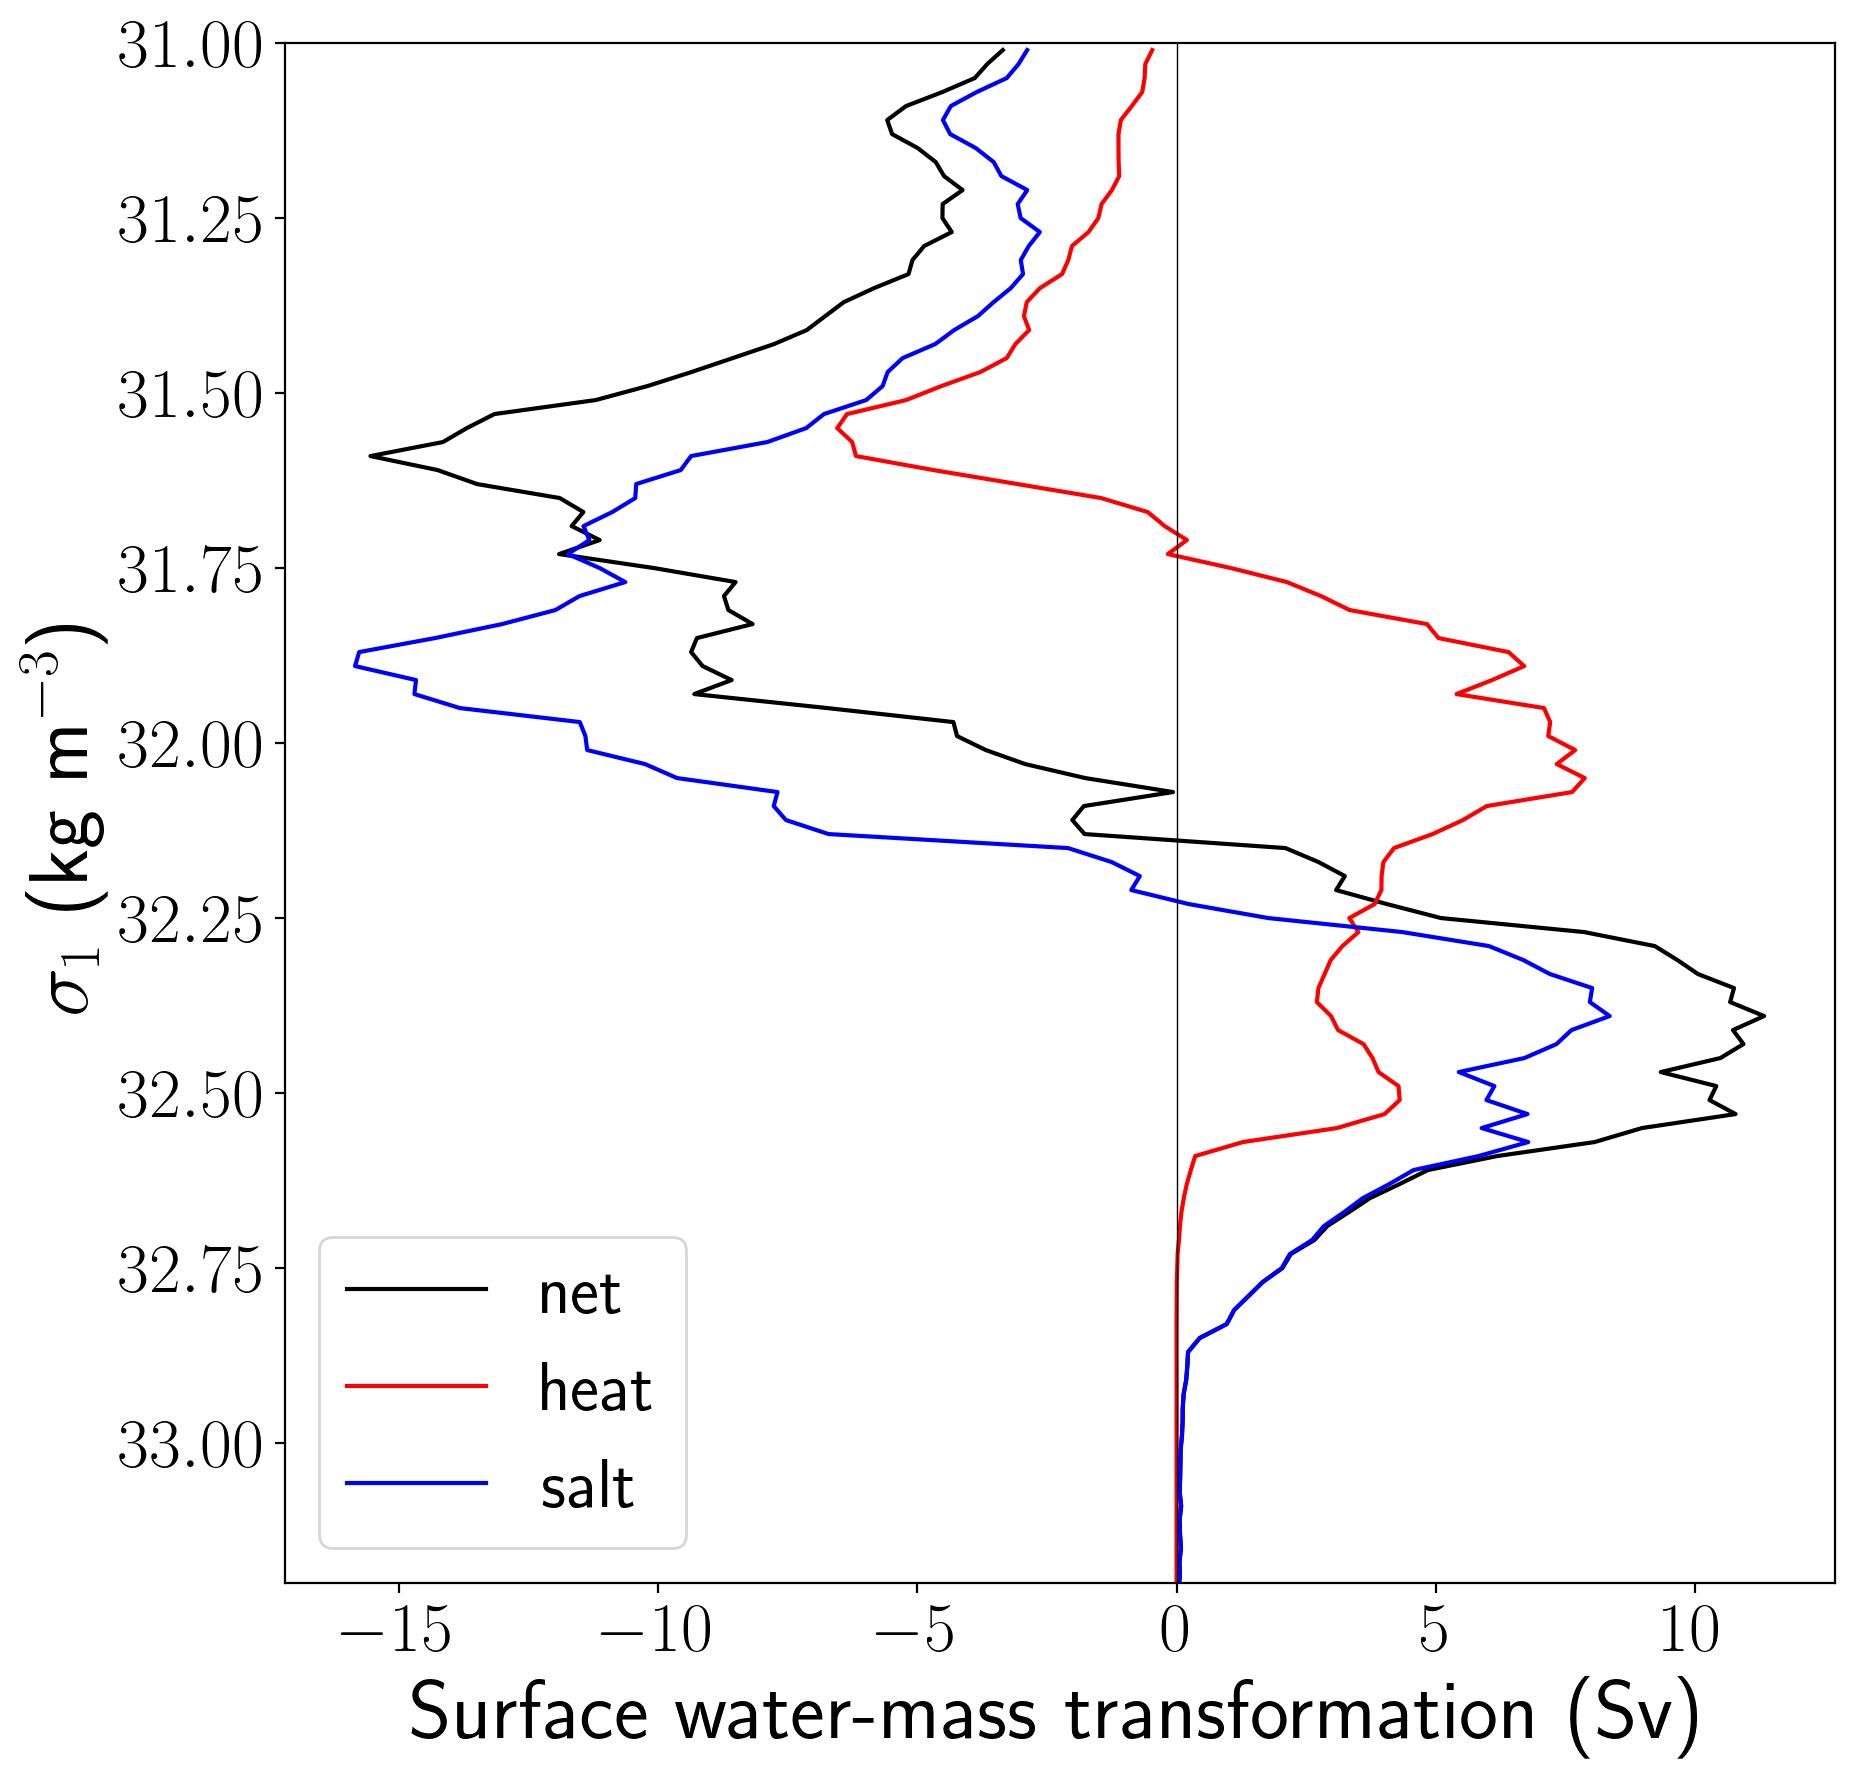

In [9]:
figure = plt.figure(num=1, figsize = (10, 10))

plt.plot(swmt_sum, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_sum, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_sum, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

Here the positive peak in the high density classes indicates a rate of subduction due to surface densification processes (predominantly freshwater fluxes associated with sea-ice processes in this case). The negative peak indicates upwelling rates. 

## 4.3 Plotting options: Antarctic shelf dense water formation

You might be interested in dense water formation on the Anarctic continental shelf. Below we've outlined a procedure whereby you can identify the density of subducting waters on the continental shelf, and map the locations where this sudbuction occurs.

You will need a way of masking for the continental shelf. You might just use a simple depth criterion, but here I define the shelf region using a mask that selects cells poleward of a continuous approximation of the 1000 m isobath surrounding Antarctica.

**Warning**: Shelf masking is model-specific, and can only be used for ACCESS-OM2 and PanAntartic simulations so far. 

In [10]:
def shelf_mask_isobath(var, model_dict):
    '''
    Masks ACCESS-OM2-01 and Pan-Antarctic variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison. Panan isobath created by Christina Schmidt"
    Only to be used with ACCESS-OM2-0.1 and Pan-Antarctic output!
    '''
    var = var.cf.sel({'latitude' : slice(-90, -59)})
    if model_dict['contour_dir'][-3:] == '.nc':
        shelf_mask = xr.open_dataset(model_dict['contour_dir'])['contour_masked_above']

    else:
        contour_file = np.load(model_dict['contour_dir'])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'], coords = [var.cf['latitude'], var.cf['longitude']], dims = [var.cf['latitude'].name, var.cf['longitude'].name], name = 'contour_masked_above')
    
    #shelf_mask = contour_file['contour_masked_above']
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1; shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    masked_var = var * shelf_mask
    

    return masked_var, shelf_mask

Below we've plotted the positioning of this isobath boundary.

In [11]:
ht = cc.querying.getvar(expt, model_dict['maximum_depth'], session, n=1).drop({'geolon_t','geolat_t'},errors='ignore')
ht = ht.cf.sel({'latitude' : slice(-90, -59)})

land_mask = (ht*0).fillna(1)
yt_ocean = ht.cf['latitude'].values
xt_ocean = ht.cf['longitude'].values
ht_shelf, shelf_mask = shelf_mask_isobath(ht, model_dict)

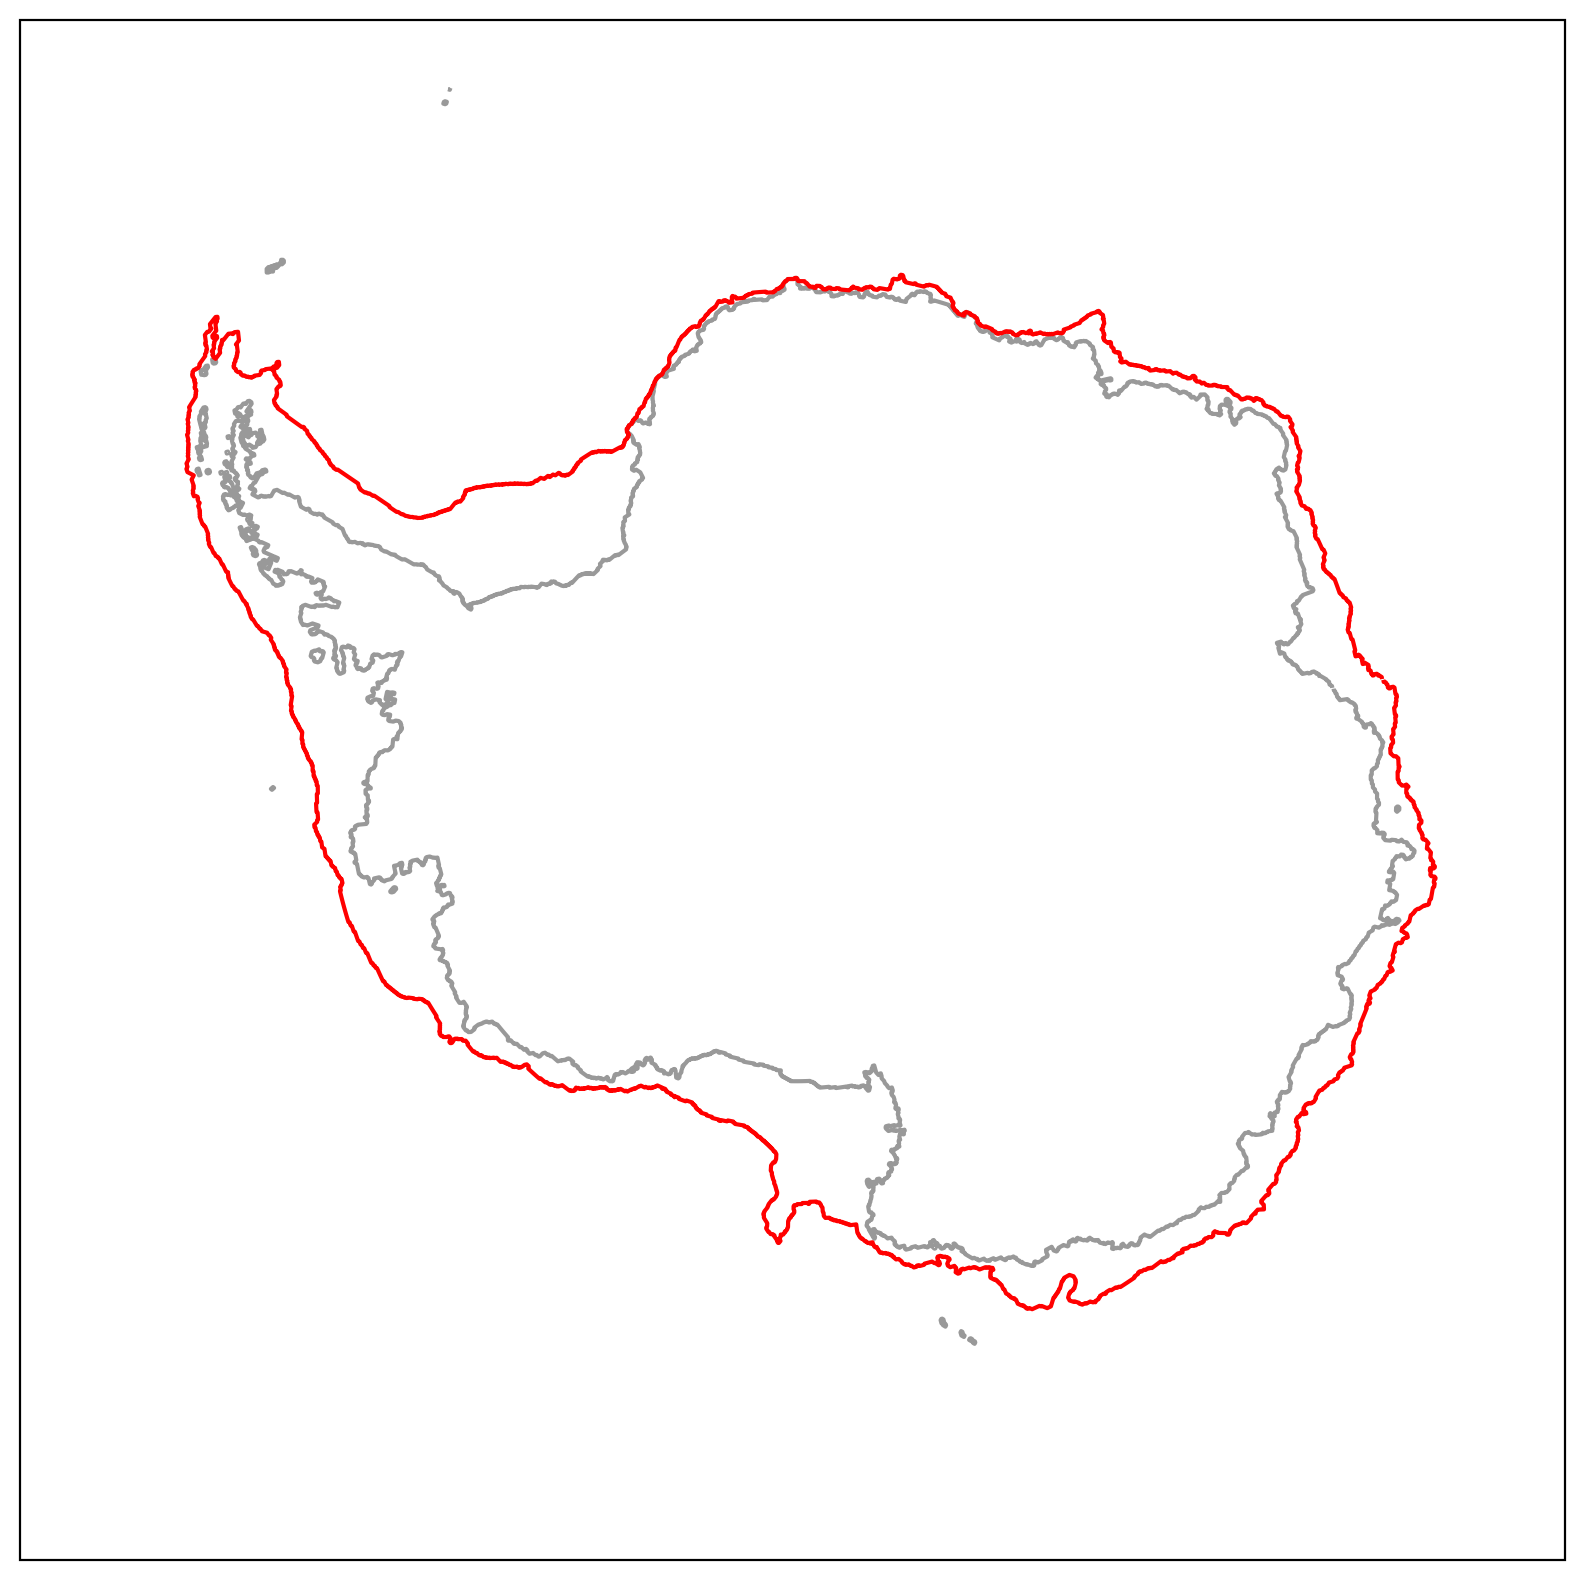

In [12]:
fig = plt.figure(num=1,figsize=(10, 10))

ax = plt.subplot(projection=ccrs.SouthPolarStereo())
ax.contour(land_mask.cf['longitude'], land_mask.cf['latitude'], land_mask, [0, 1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(shelf_mask.cf['longitude'], shelf_mask.cf['latitude'], shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

Now we'll repoduce the previous surface water-mass transformation plot but for the continental shelf region only.

In [13]:
swmt_shelf, shelf_mask = shelf_mask_isobath(swmt, model_dict)
heat_shelf, shelf_mask = shelf_mask_isobath(heat, model_dict)
salt_shelf, shelf_mask = shelf_mask_isobath(salt, model_dict)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t, model_dict)
swmt_shelf_sum = (swmt_shelf * area_t_shelf / 1e6).sum([shelf_mask.cf['longitude'].name, shelf_mask.cf['latitude'].name]).values
heat_shelf_sum = (heat_shelf * area_t_shelf / 1e6).sum([shelf_mask.cf['longitude'].name, shelf_mask.cf['latitude'].name]).values
salt_shelf_sum = (salt_shelf * area_t_shelf / 1e6).sum([shelf_mask.cf['longitude'].name, shelf_mask.cf['latitude'].name]).values

Text(0.5, 1.0, '01deg_jra55v13_ryf9091')

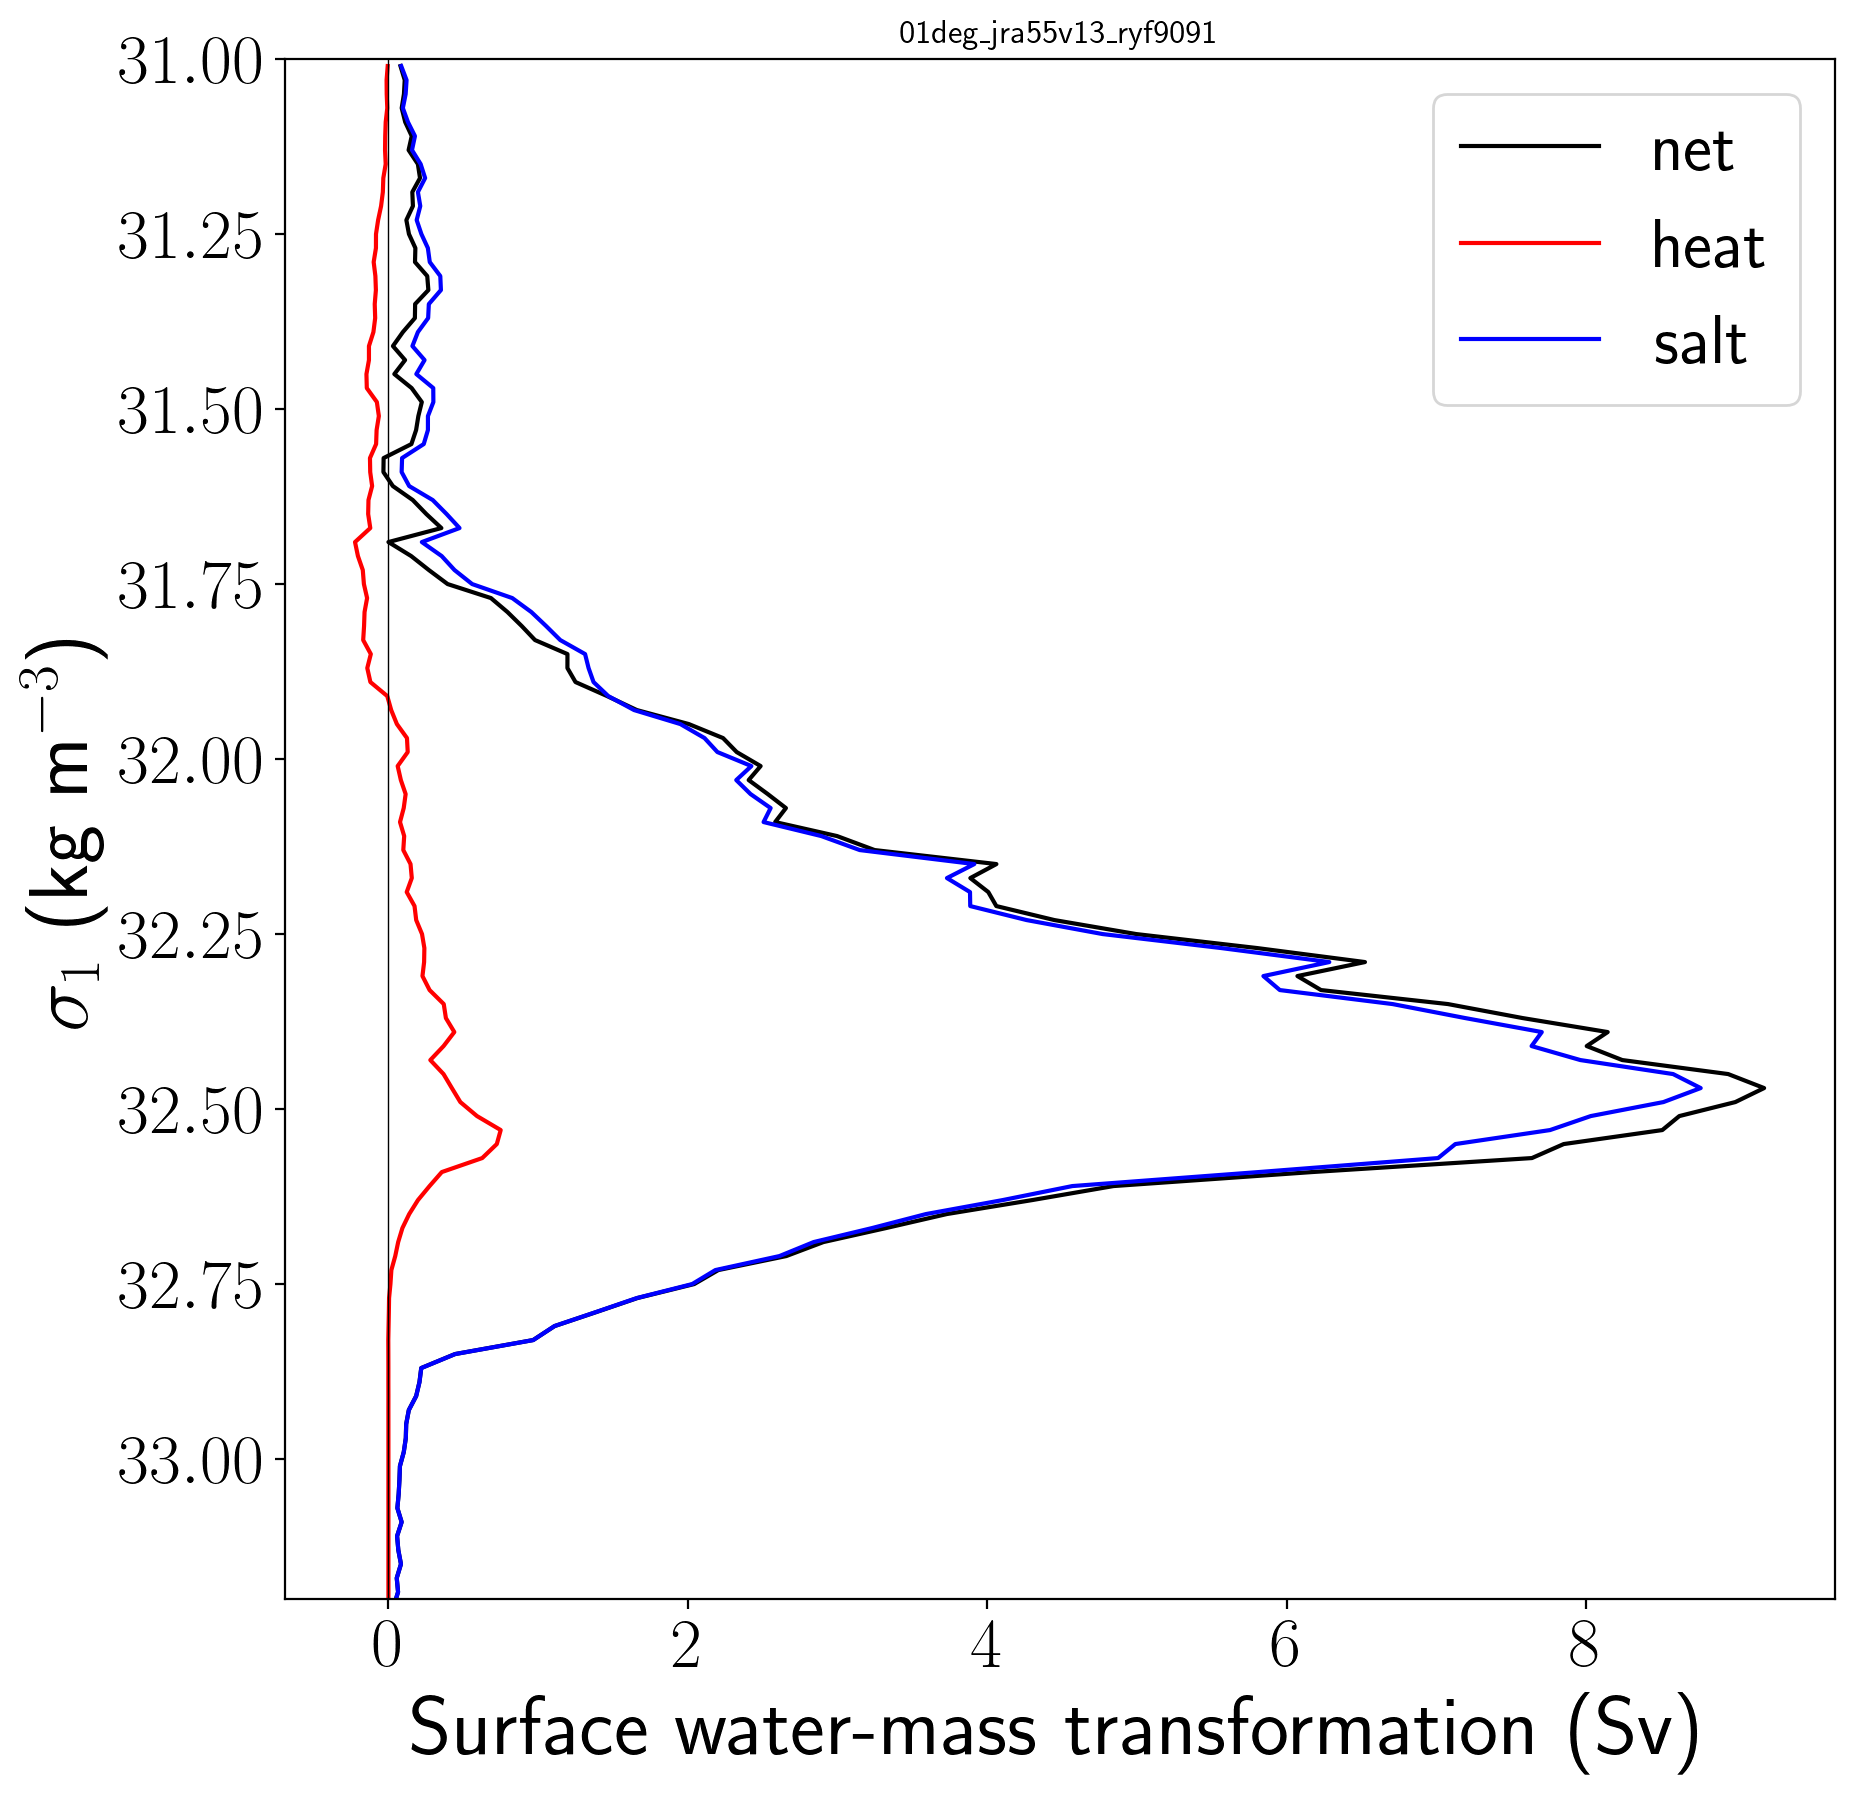

In [14]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_shelf_sum, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_shelf_sum, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_shelf_sum, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);
plt.title(expt)

This shows us that continental shelf surface waters are made denser (almost entirely by sea-ice freshwater fluxes) and subduct away from the surface at a rate of over 8 Sv! Where does this happen? If we map the surface water-mass transformation rate across a chosen density class, we will be able to see where waters are subducting. We know from experience that the dense waters that overflow are best correlated with the transformation on the denser side of the peak, so let's choose $\sigma_1$ = 32.6 kg/m^3.

In [15]:
transformation_density = 32.6

shelf_subduction_plot = swmt_shelf.sel(isopycnal_bins = transformation_density, method='nearest') * 1e5
swmt_xt = ht_shelf.cf['longitude']
swmt_yt = ht_shelf.cf['latitude']

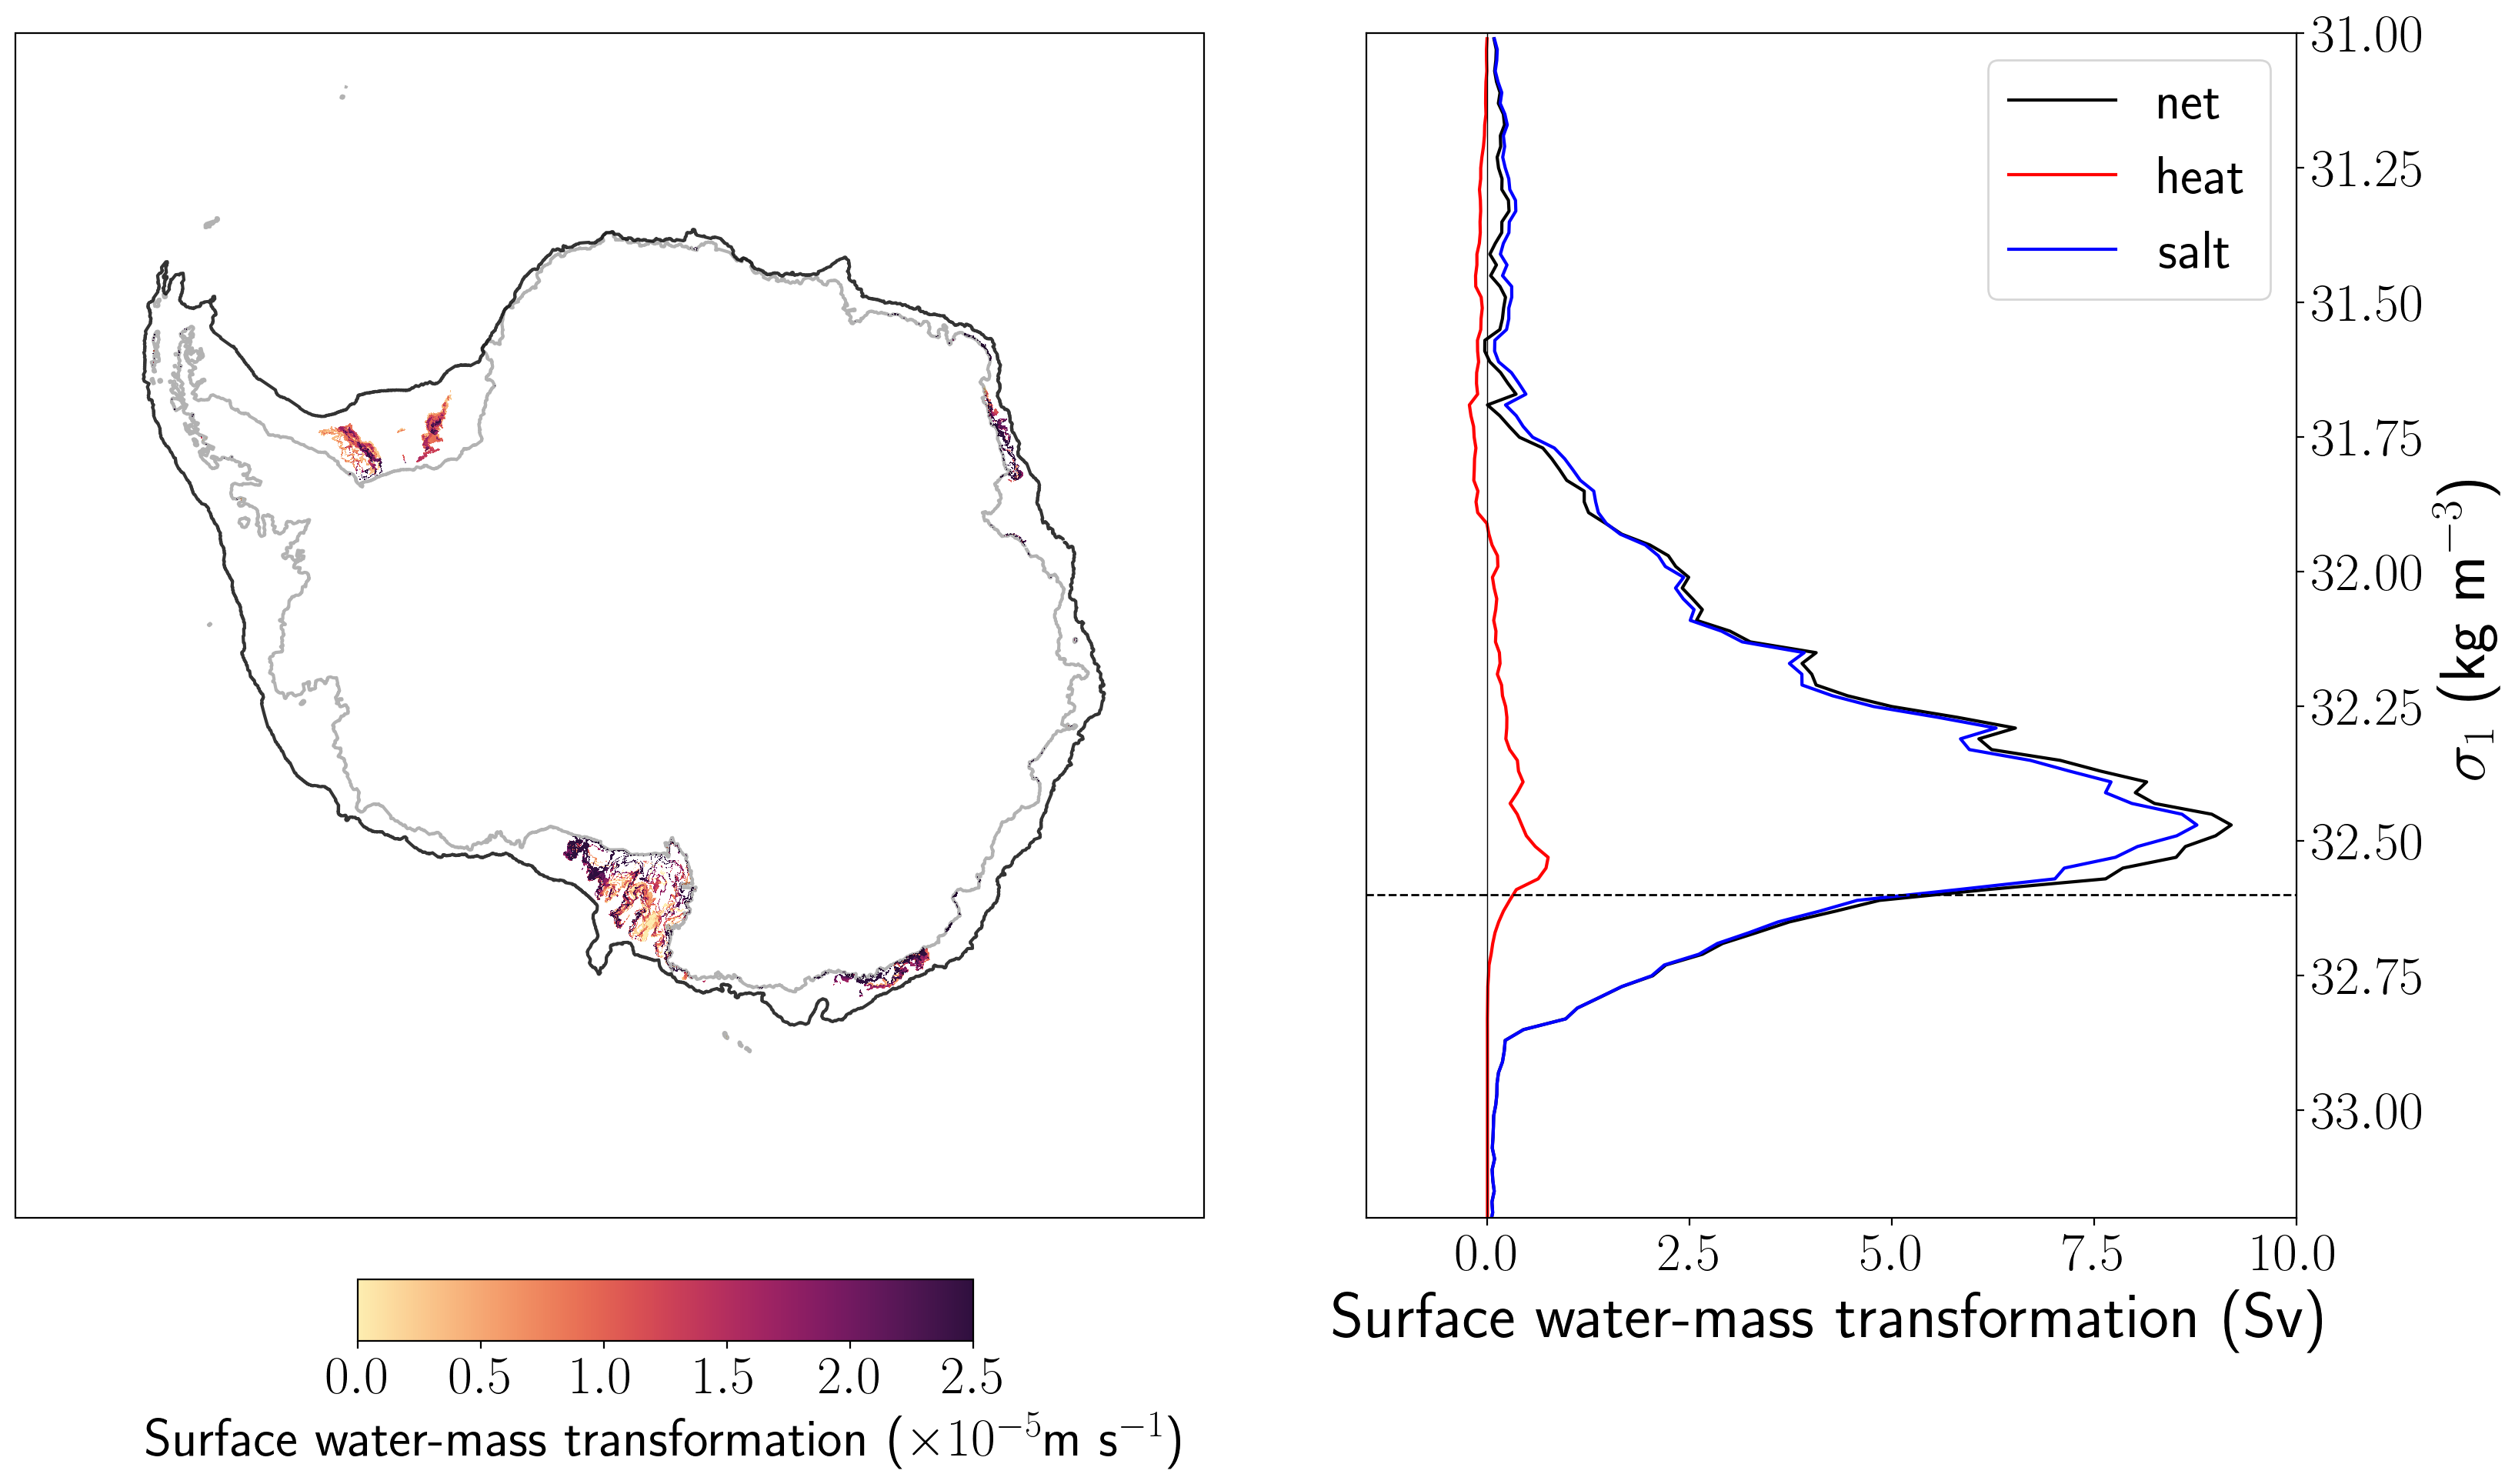

In [16]:
fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [3, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1])

ax.contour(xt_ocean, yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3, transform = ccrs.PlateCarree() )
ax.contour(shelf_mask.cf['longitude'], shelf_mask.cf['latitude'], shelf_mask, [0, 1],
           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin=0, vmax=2.5, cmap=cmo.matter,transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-5}$m s$^{-1}$)', fontsize = 25)

ax1.plot(swmt_shelf_sum, isopycnal_bin_mid, color = 'k',label='net')
ax1.plot(heat_shelf_sum, isopycnal_bin_mid, color = 'r',label='heat')
ax1.plot(salt_shelf_sum, isopycnal_bin_mid, color = 'b',label='salt')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [transformation_density, transformation_density],'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
ax1.set_xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
ax1.legend(loc=1, fontsize = 25);

The map in the left panel shows the spatial distribution of surface water-mass transformation across the density class indicated with the dashed line in the right panel. We see the 4 main dense water formation sites around Antarctica, how nice!

## 5. MOM6 example

In [17]:
expt = 'panant-01-zstar-ACCESSyr2'; model='mom6'

In [18]:
%%time
## Make a temporary directory to stash a few files
!mkdir -p SWMT_temp
outpath = '/scratch/x77/wf4500/hackathon1/' # use a path where you have write permission
outpath, time_bounds, model_dict = save_SWMT(expt, session, '2000-01', '2000-12', outpath,model=model)

salt_transformation binning done
heat_transformation binning done
CPU times: user 1min 55s, sys: 1min 35s, total: 3min 30s
Wall time: 3min 18s


In [19]:
def get_SWMT(outpath, time_bounds):

    net_transformation = xr.open_dataset(outpath + '/SWMT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + '/HT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + '/ST_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation

In [20]:
area_t = cc.querying.getvar(expt, model_dict['area'], session, n=1).drop({'geolon_t','geolat_t'},errors='ignore') # needed for the plots I'll provide.
swmt, heat, salt = get_SWMT(outpath, time_bounds)

#Necessary attribute tagging so cf xarray can identify the longitude and latitude variables:
swmt[area_t.cf['latitude'].name].attrs= {'standard_name':'latitude'} ; swmt[area_t.cf['longitude'].name].attrs= {'standard_name':'longitude'}
heat[area_t.cf['latitude'].name].attrs= {'standard_name':'latitude'} ; heat[area_t.cf['longitude'].name].attrs= {'standard_name':'longitude'}
salt[area_t.cf['latitude'].name].attrs= {'standard_name':'latitude'} ; salt[area_t.cf['longitude'].name].attrs= {'standard_name':'longitude'}

## sum over region, convert to Sv
isopycnal_bin_mid = swmt.isopycnal_bins
swmt_sum = (swmt * area_t / 1e6).sum([area_t.cf['longitude'].name, area_t.cf['latitude'].name]).values
heat_sum = (heat * area_t / 1e6).sum([area_t.cf['longitude'].name, area_t.cf['latitude'].name]).values
salt_sum = (salt * area_t / 1e6).sum([area_t.cf['longitude'].name, area_t.cf['latitude'].name]).values

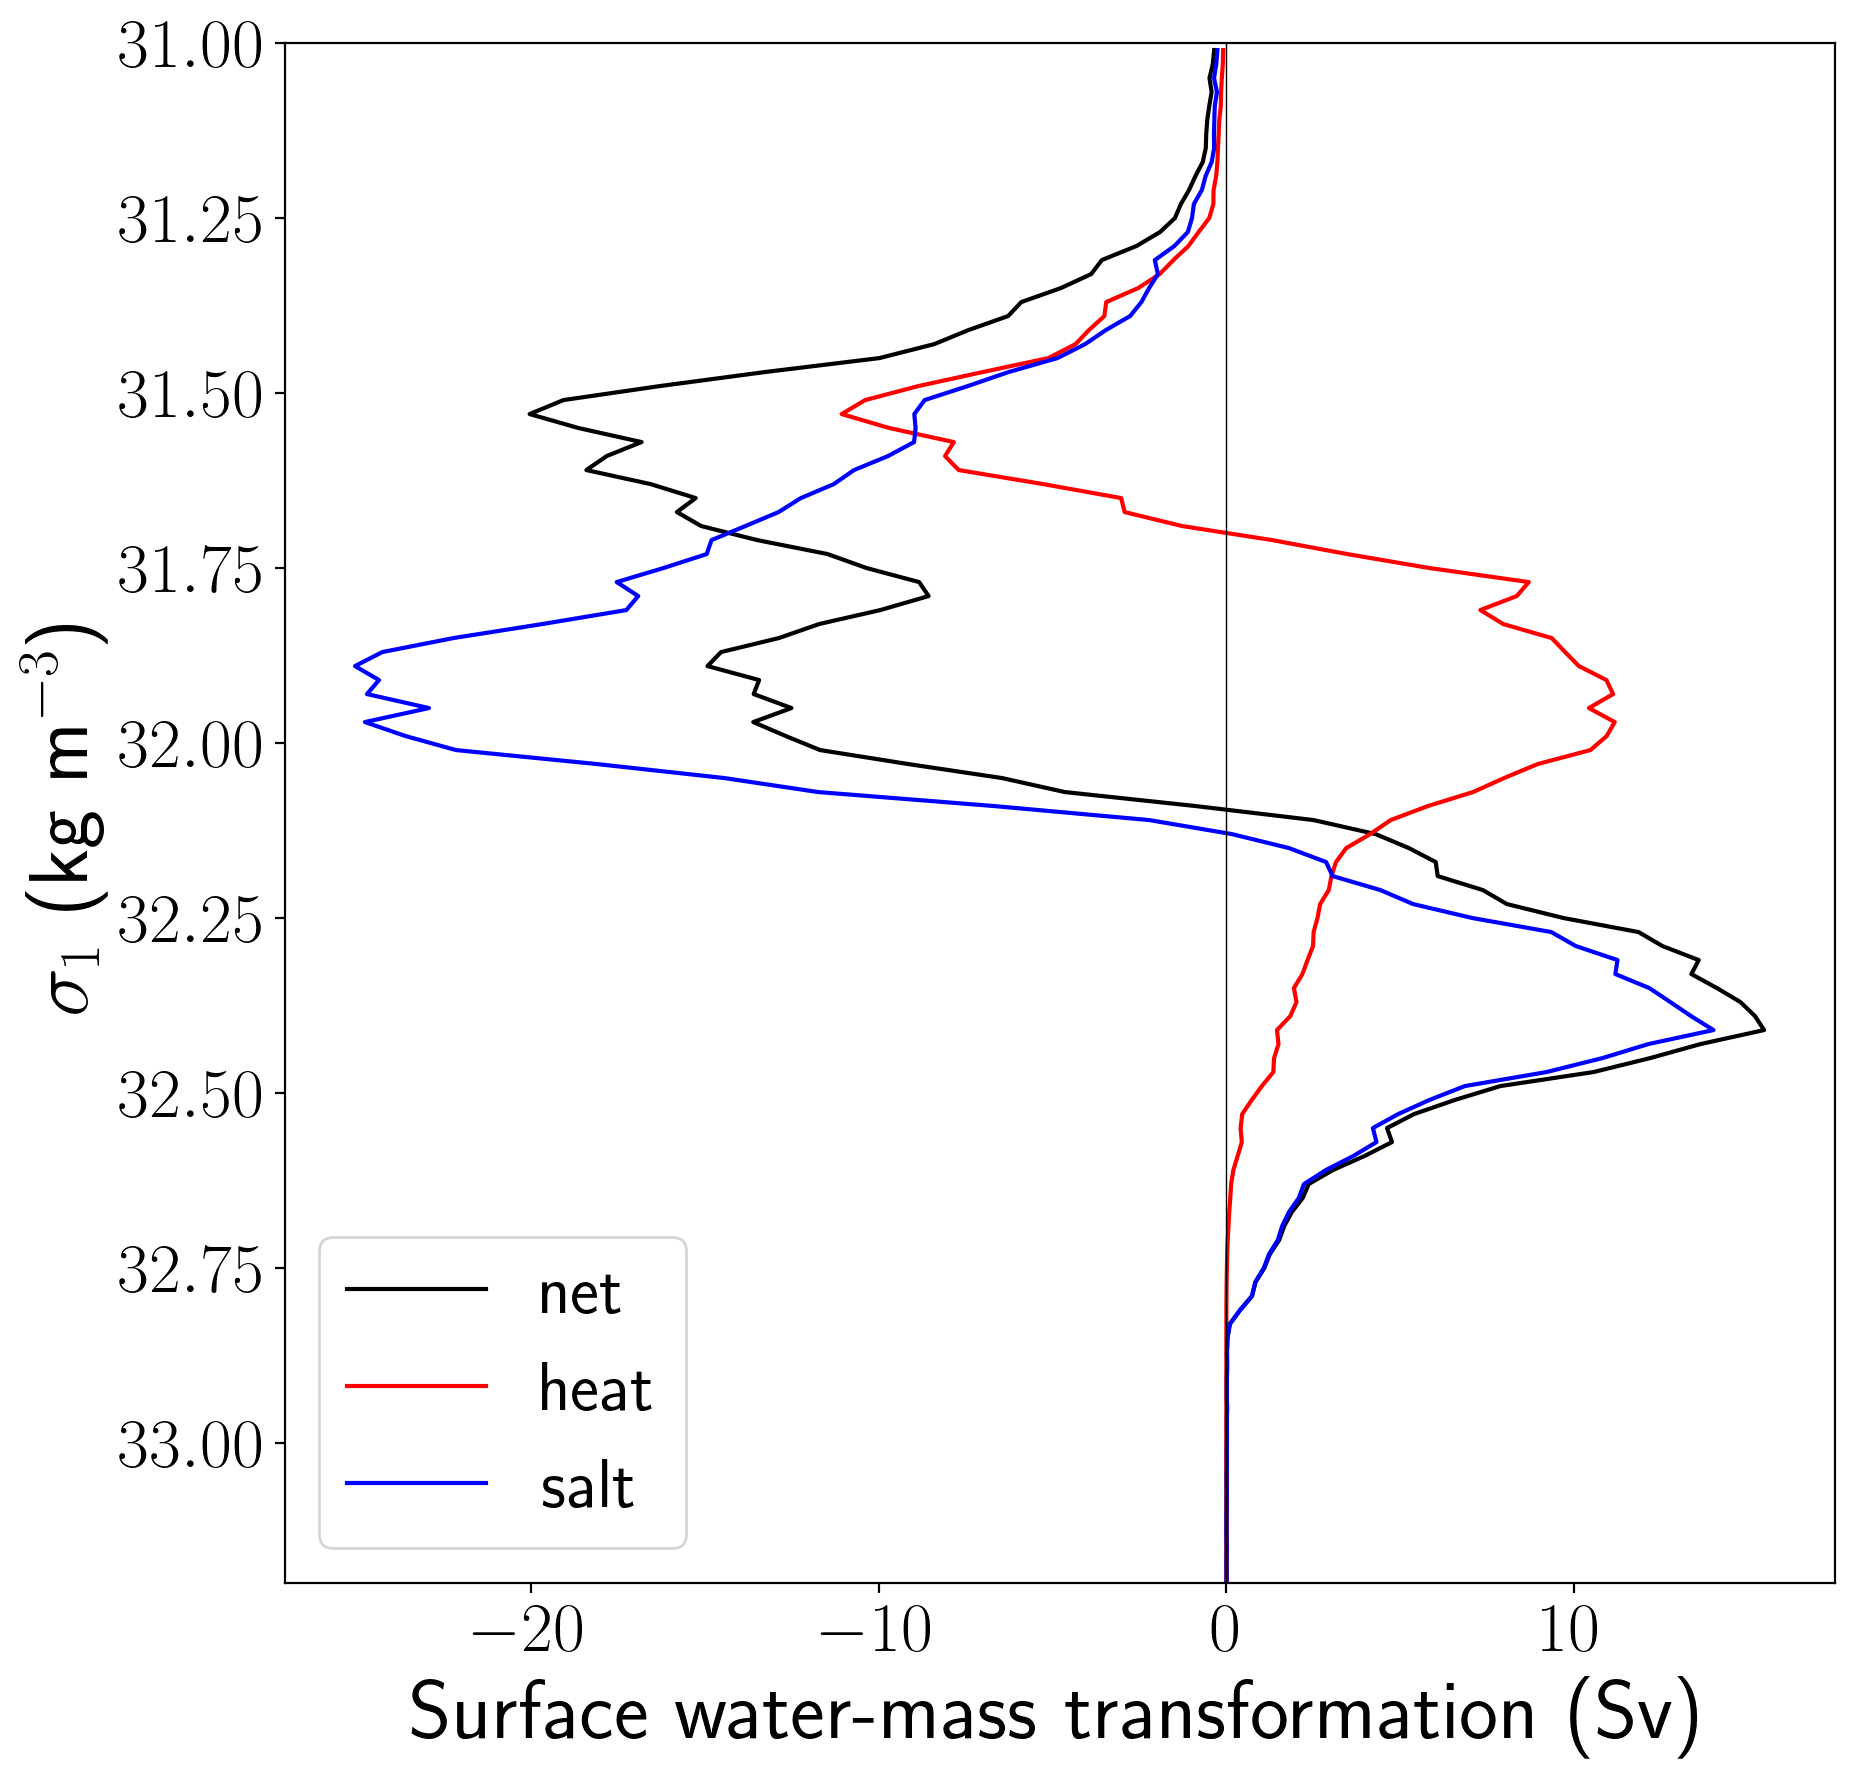

In [21]:
figure = plt.figure(num=1, figsize = (10, 10))

plt.plot(swmt_sum, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_sum, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_sum, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

In [22]:
ht = cc.querying.getvar(expt, model_dict['maximum_depth'], session, n=1).drop({'geolon_t','geolat_t'},errors='ignore')
ht = ht.cf.sel({'latitude' : slice(-90, -59)})

land_mask = (ht*0).fillna(1)
yt_ocean = ht.cf['latitude'].values
xt_ocean = ht.cf['longitude'].values
ht_shelf, shelf_mask = shelf_mask_isobath(ht,model_dict)

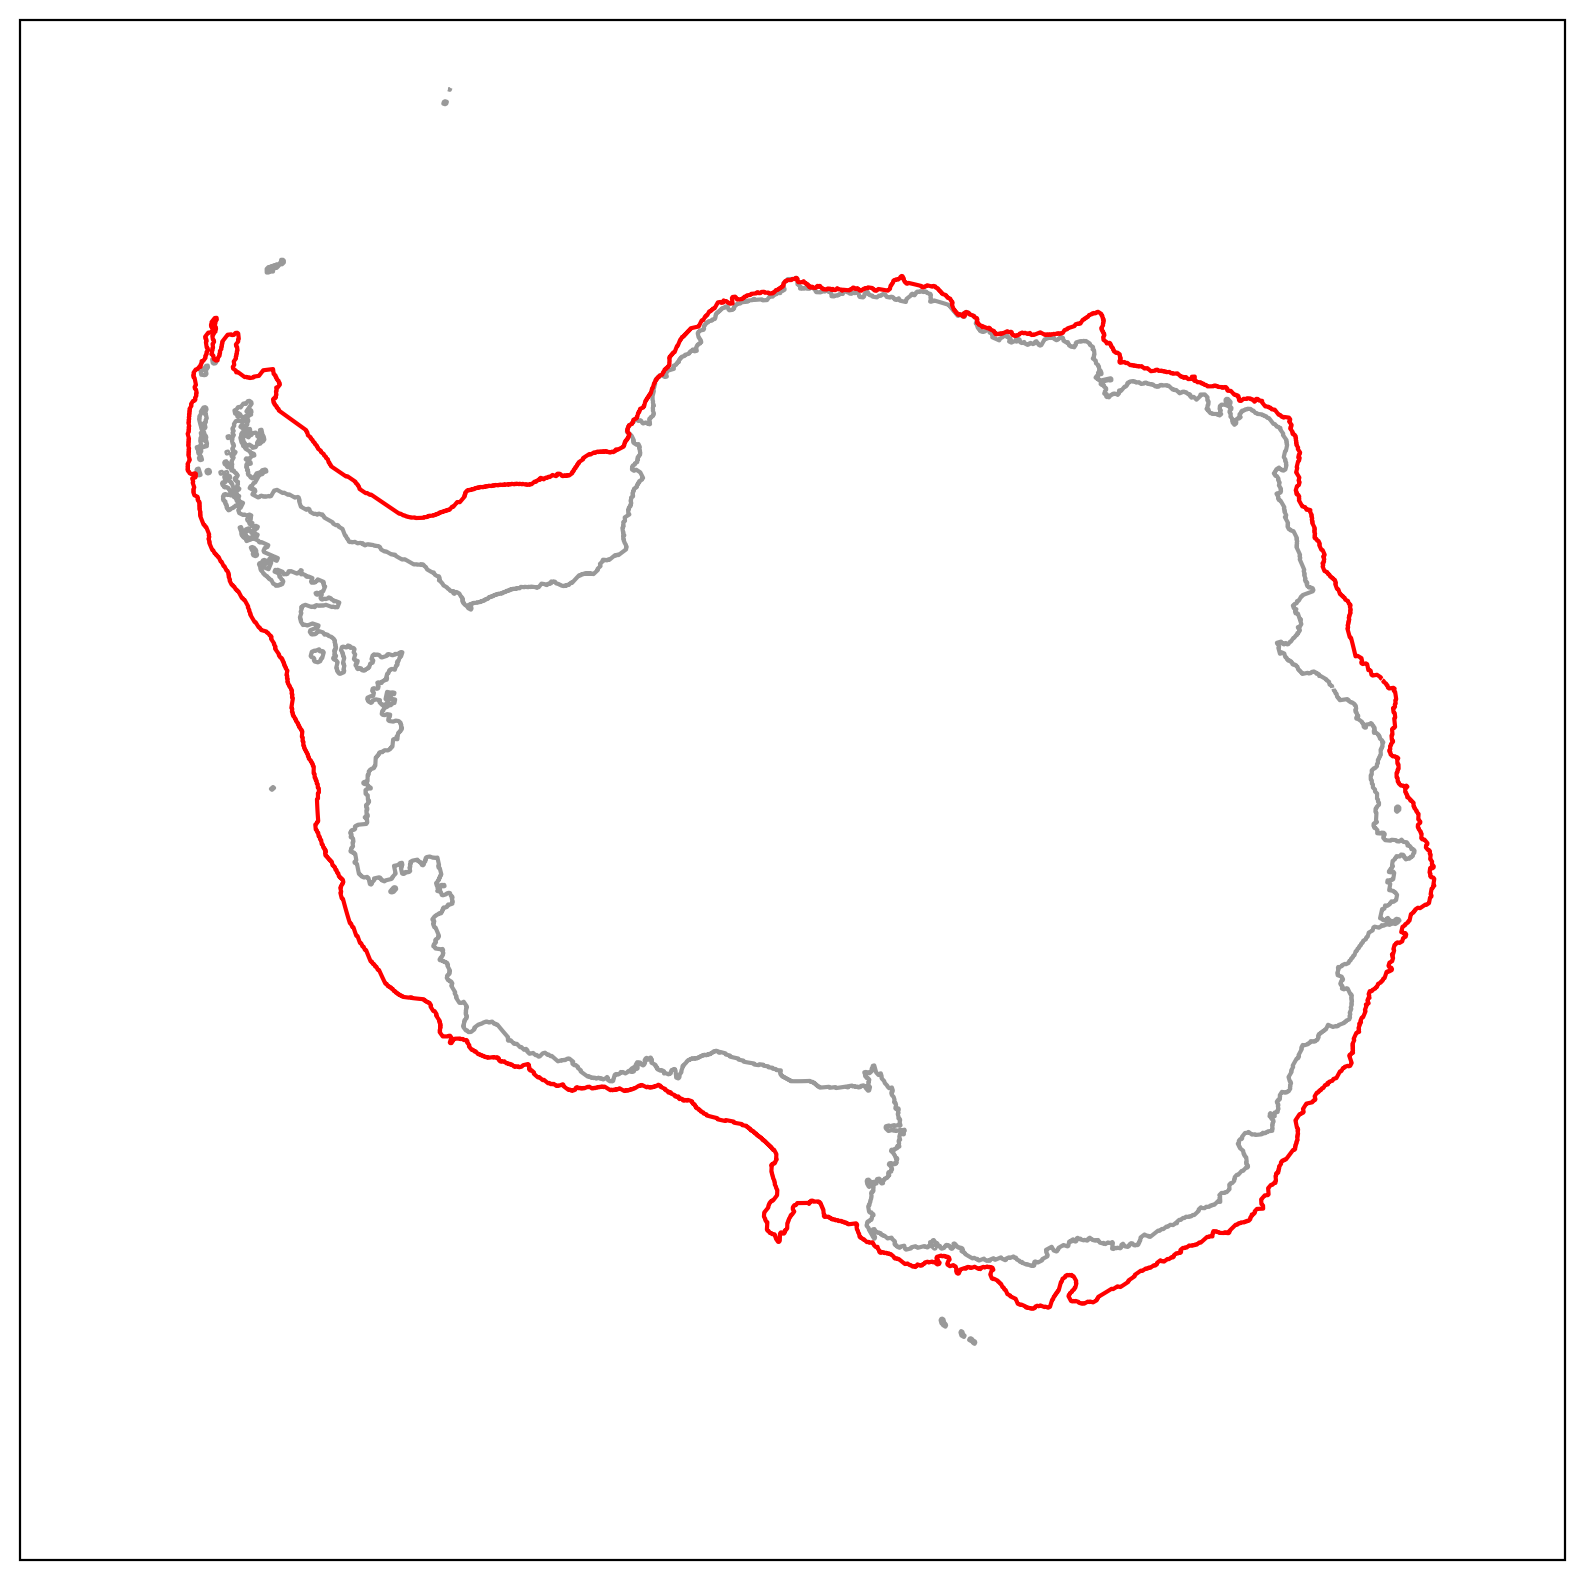

In [23]:
fig = plt.figure(num=1,figsize=(10, 10))

ax = plt.subplot(projection=ccrs.SouthPolarStereo())
ax.contour(land_mask.cf['longitude'], land_mask.cf['latitude'], land_mask, [0, 1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(shelf_mask.cf['longitude'], shelf_mask.cf['latitude'], shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

In [24]:
swmt_shelf, shelf_mask = shelf_mask_isobath(swmt, model_dict)
heat_shelf, shelf_mask = shelf_mask_isobath(heat, model_dict)
salt_shelf, shelf_mask = shelf_mask_isobath(salt, model_dict)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t, model_dict)
swmt_shelf_sum = (swmt_shelf * area_t_shelf / 1e6).sum([shelf_mask.cf['longitude'].name, shelf_mask.cf['latitude'].name]).values
heat_shelf_sum = (heat_shelf * area_t_shelf / 1e6).sum([shelf_mask.cf['longitude'].name, shelf_mask.cf['latitude'].name]).values
salt_shelf_sum = (salt_shelf * area_t_shelf / 1e6).sum([shelf_mask.cf['longitude'].name, shelf_mask.cf['latitude'].name]).values

Text(0.5, 1.0, 'panant-01-zstar-ACCESSyr2')

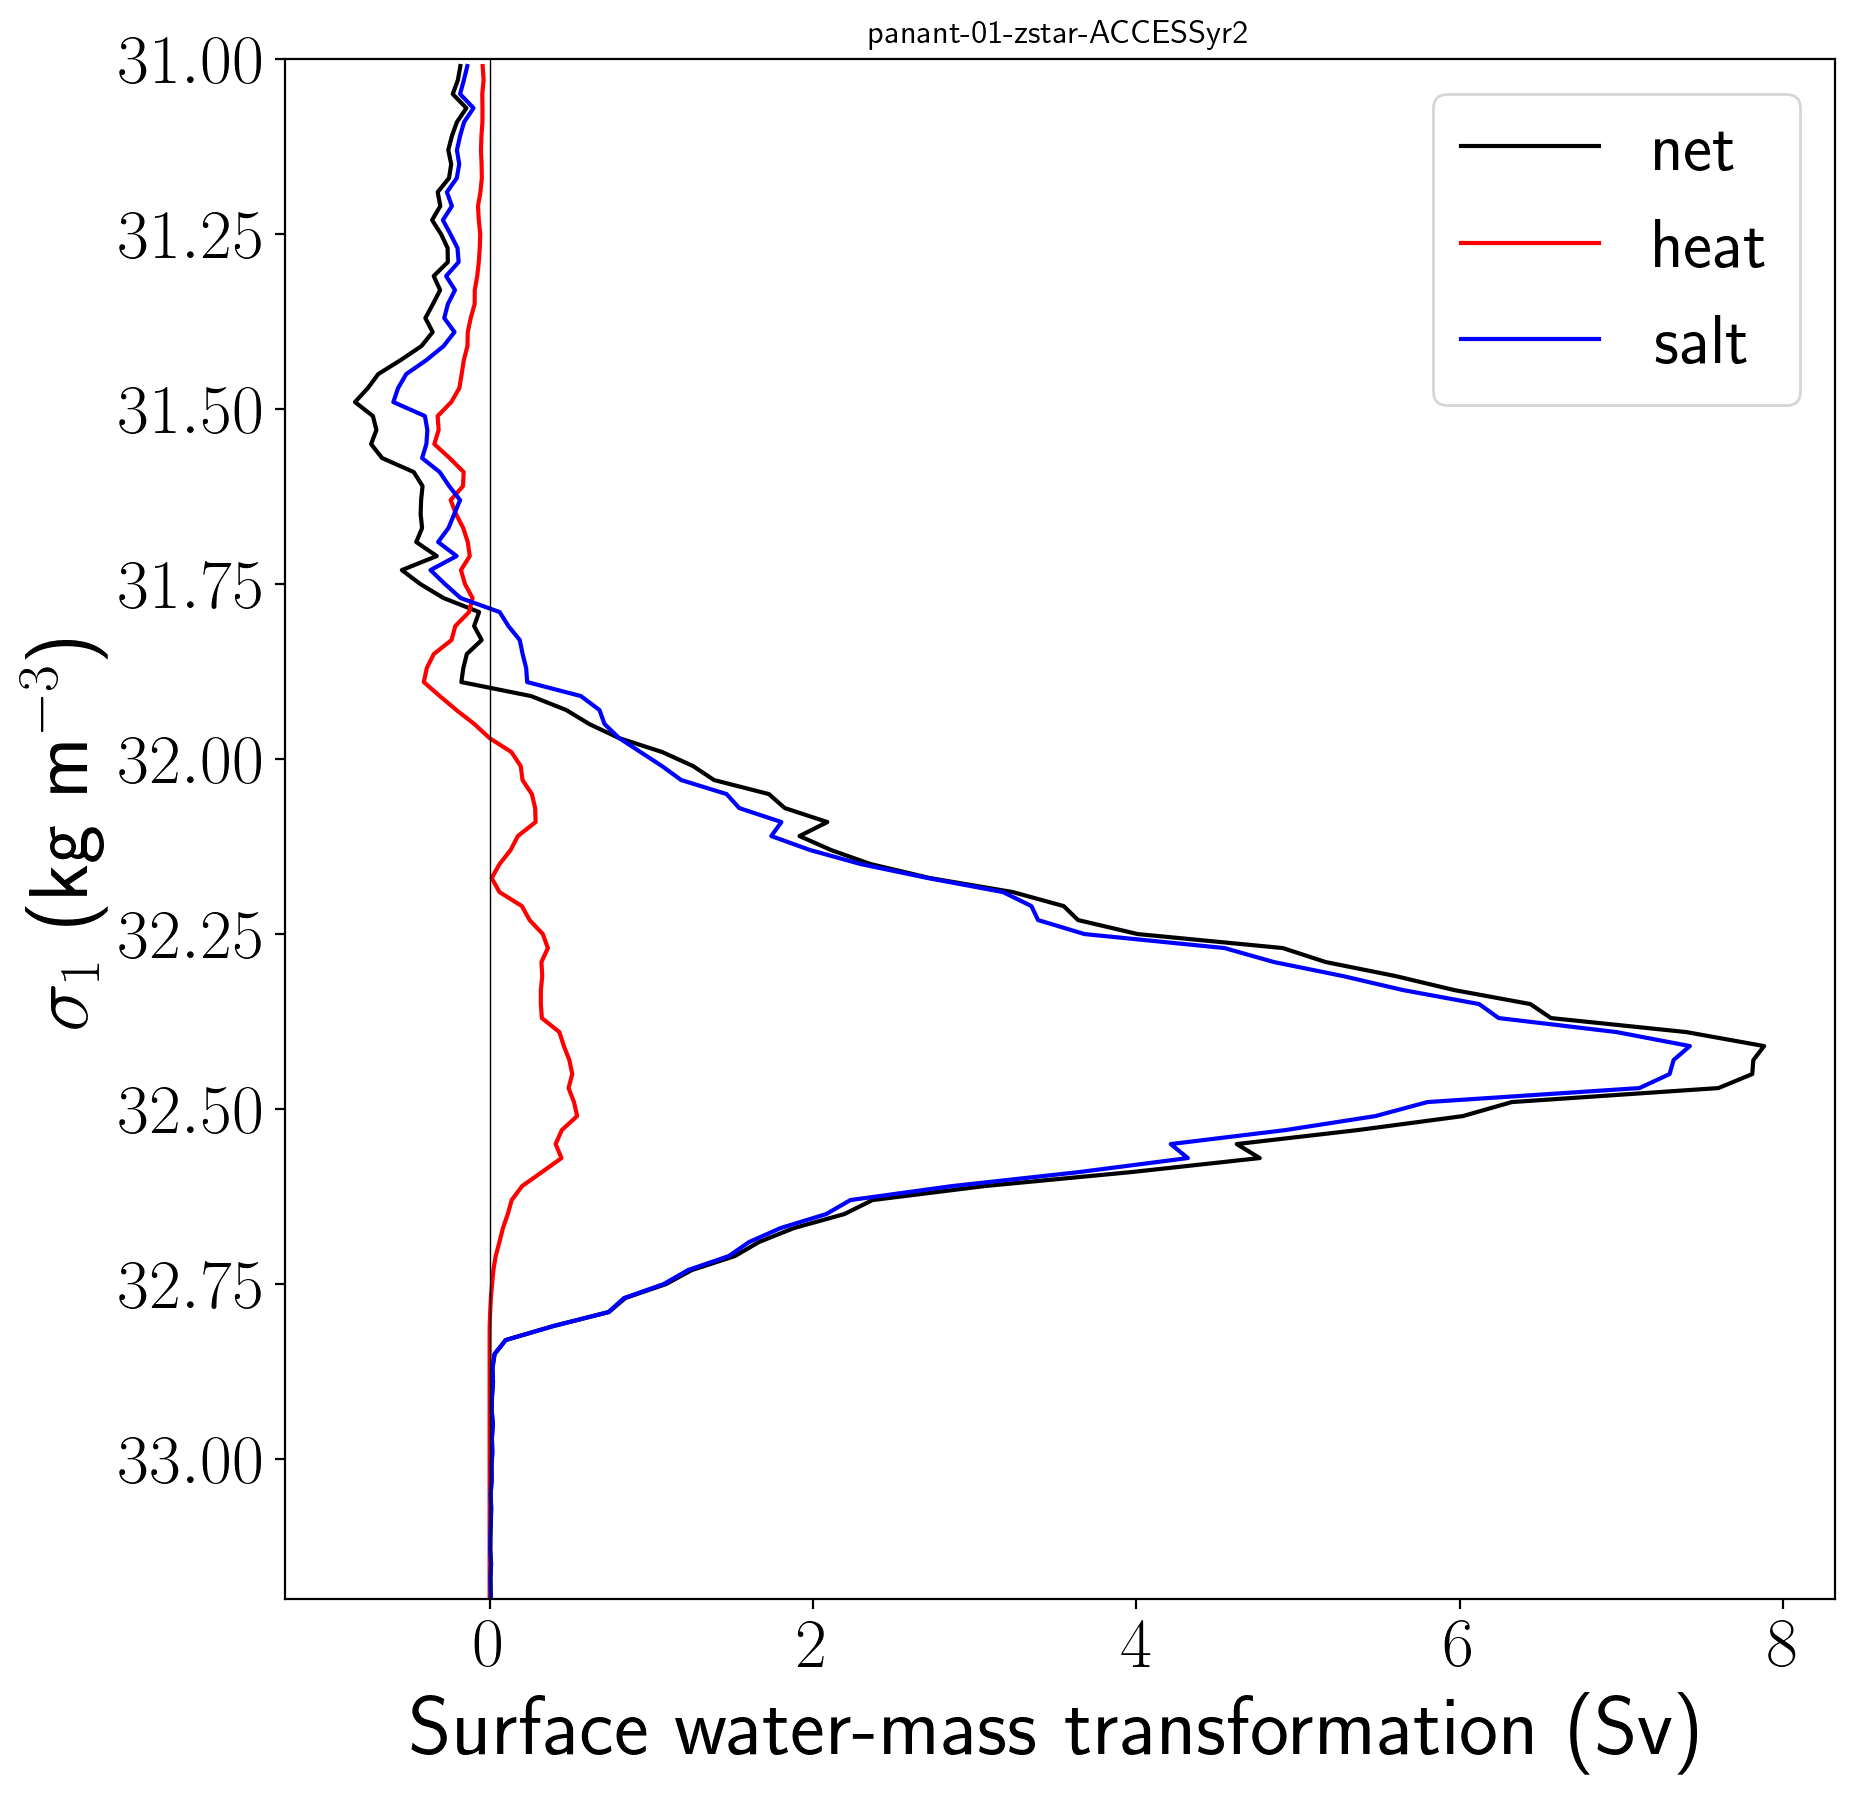

In [25]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_shelf_sum, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_shelf_sum, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_shelf_sum, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);
plt.title(expt)

In [26]:
transformation_density = 32.6

shelf_subduction_plot = swmt_shelf.sel(isopycnal_bins = transformation_density, method='nearest') * 1e5
swmt_xt = ht_shelf.cf['longitude']
swmt_yt = ht_shelf.cf['latitude']

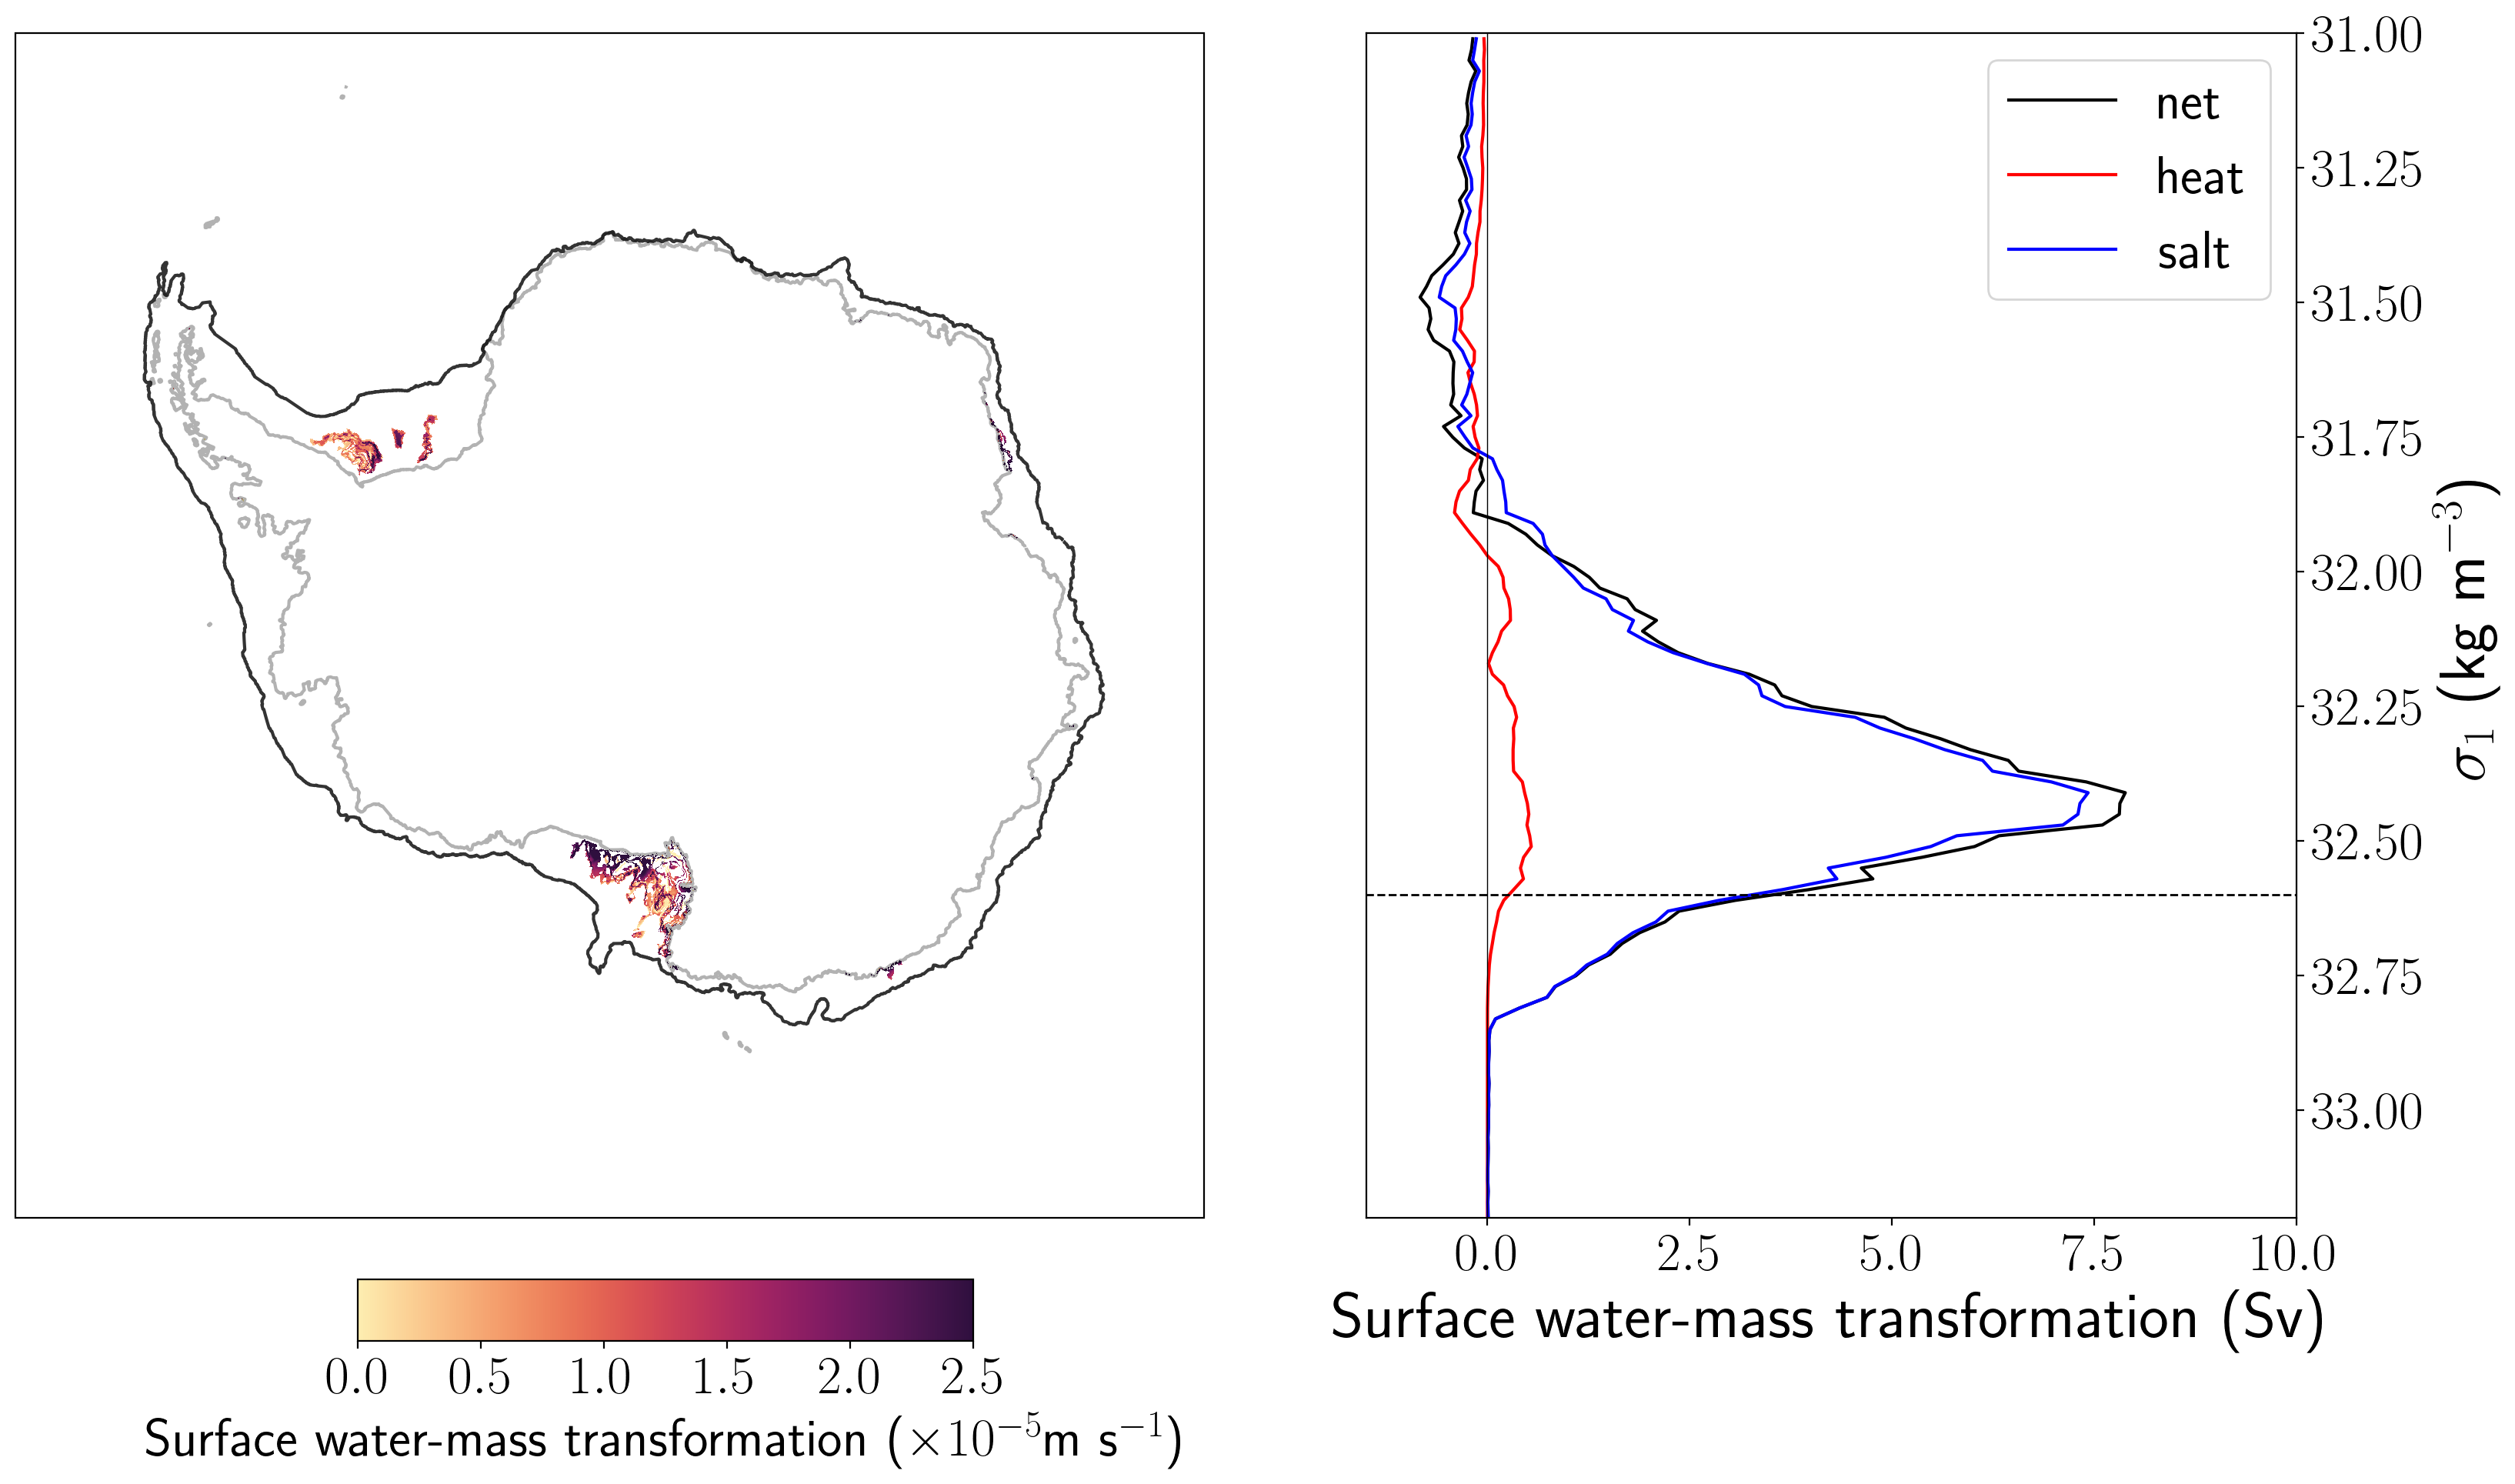

In [27]:
fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [3, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1])

ax.contour(xt_ocean, yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3, transform = ccrs.PlateCarree() )
ax.contour(shelf_mask.cf['longitude'], shelf_mask.cf['latitude'], shelf_mask, [0, 1],
           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin=0, vmax=2.5, cmap=cmo.matter,transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-5}$m s$^{-1}$)', fontsize = 25)

ax1.plot(swmt_shelf_sum, isopycnal_bin_mid, color = 'k',label='net')
ax1.plot(heat_shelf_sum, isopycnal_bin_mid, color = 'r',label='heat')
ax1.plot(salt_shelf_sum, isopycnal_bin_mid, color = 'b',label='salt')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [transformation_density, transformation_density],'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
ax1.set_xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
ax1.legend(loc=1, fontsize = 25);